In [ ]:
""" to take task object and parse correctly
use sets of pts, find all intersections ,etc [new code]
construct sekleton and then use old code for walking along skeleton.
"""


In [ ]:
import shapely as sl


In [ ]:
from pythonlib.dataset.dataset import Dataset
import matplotlib.pyplot as plt

In [ ]:
### Load a dataset, to have tasks to test
# animal = "Diego"
# expt = "linecircle"
# rule = "null"
animal = "Pancho"
expt = "lines5"
rule = "straight"
D = Dataset([])
D.load_dataset_helper(animal, expt, ver="mult", rule=rule)
D.load_tasks_helper()


### EXTRACT AND SAVE PARSES

In [ ]:
### Load a dataset, to have tasks to test
animal = "Diego"
expt = "linecircle"
rule = "null"
D = Dataset([])
D.load_dataset_helper(animal, expt, rule=rule)
D.load_tasks_helper()

In [ ]:
# Extract
D.parser_extract_and_save_parses(quick=True)

### BELOW: DEVELOPMENT

#### Playing around with shapely

In [ ]:
# Pull out a task with circle overlapping line

# charnum = "03659" # line,circle, separate
# charnum = "78590" # lollipop
# charnum = "69036" # harder, 2 lollis
charnum = "48436" # hardest, 2 lollis
task = [(i, n) for i, n in enumerate(D.Dat["character"].to_list()) if charnum in n][0]

print(task)

D.plotSingleTrial(task[0]);

# Task struct
T = D.Dat.iloc[task[0]]["Task"]




In [ ]:
from shapely.geometry import LineString, LinearRing, MultiLineString, GeometryCollection
# line = LineString([(0, 0), (1, 1)])
# circ = LinearRing([(0, 0), (1, 1), (1, 0)])



In [ ]:
print(T.Shapes)

# make line
ptsl = T.Strokes[0][:,:2]
line = LineString(ptsl)

# make circle
pts = T.Strokes[1][:,:2]
# make sure first pt is repeated at end
# circ = LineString(pts)
circ = LinearRing(pts)

# make into collection?
ls = MultiLineString((line, circ))


# Get intersection
intersection = line.intersection(circ)

In [ ]:
line.xy

In [ ]:
plt.figure()
plt.plot(*line.xy, ".-")
plt.plot(ptsl[0,0],ptsl[0,1], "ok")
plt.plot(ptsl[-1,0],ptsl[-1,1], "ok")
plt.plot(*circ.xy, ".-")

if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'ok')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'ok')
    


In [ ]:
inters.geom_type

In [ ]:
# Get intersection
# ls = MultiLineString((line, circ))

inters = line.intersection(circ)
if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o')


In [ ]:
D.Dat["unique_task_name"]

In [ ]:
circ
line

In [ ]:
from shapely.ops import polygonize
lines = [
     ((0, 0), (1, 1)),
     ((0, 0), (0, 1)),
     ((0, 1), (1, 1)),
     ((1, 1), (1, 0)),
     ((1, 0), (0, 0))
     ]
a = polygonize(lines)
# pprint(list(polygonize(lines)))
# [<shapely.geometry.polygon.Polygon object at 0x...>,
# <shapely.geometry.polygon.Polygon object at 0x...>]


In [ ]:

for a1 in a:
    print(a1)
    plt.plot(a1.coords)
#     x = a1

In [ ]:
from shapely.ops import shared_paths, split
shared_paths(line, circ)
s = split(line, LineString(circ))
s = split(LineString(circ), line)
s

### TRY USING sknw (as in pybpl)

In [ ]:
import numpy as np
from skimage import morphology

from sknw import build_sknw

In [ ]:
metadat = D.Metadats[0]
strokes = D.Dat.iloc[task[0]]["strokes_task"]

#### Stroke --> image, using pyBPL render
Conclusion: not ideal for me, since this puts down pts, instead of connecting them

In [ ]:
from pythonlib.drawmodel.image import convStrokecoordToImagecoord, get_sketchpad_edges_from_strokes, getSketchpadEdges
# from pythonlib.drawmodel.parsing import getSketchpadEdges

if True:
    # then use spatially interpolated
    # Leads to blurry fat strokes
    strokes_this = strokes_interp
else:
    # use orignal strokes, leaves gaps betwen pts
    strokes_this = strokes


# edges = get_sketchpad_edges_from_strokes(strokes)
# edges = edges.T
canvas_max_WH=200
image_WH = 105
sketchpad_edges, image_edges = getSketchpadEdges(canvas_max_WH, image_WH)
image_edges[1,:] = -image_edges[1,:]

strokes_img = [convStrokecoordToImagecoord(s, sketchpad_edges, image_edges) for s in strokes_this]

### trying bpl version of converting strokes to skeleton
from pybpl.rendering import render_image
import torch

strokes_torch = [torch.Tensor(s)[:,:2] for s in strokes_img]
# strokes_torch = strokes_torch[:,:, :2]
pimg = render_image(strokes_torch, epsilon=0, blur_sigma=0)
plt.figure()
plt.imshow(pimg[0], cmap='gray')


##### Strokes --> image, using my old code.

In [ ]:
%matplotlib inline

In [ ]:
# CONVERT TO SKEL - v1, 
if True:
    ske = image
    ske = morphology.remove_small_objects(ske)
    ske = morphology.remove_small_holes(ske)
#     ske = morphology.binary_erosion(ske)
#     remove_small_objects and binary_erode
    ske = morphology.skeletonize(ske).astype(np.uint16)
    plt.imshow(ske, cmap='gray')
else:
    ske = morphology.remove_small_holes(image, 2)
    ske = morphology.binary_erosion(ske)
    ske = morphology.thin(ske)
    plt.imshow(ske, cmap='gray')
    


### v3 - interpolate to <1pix, then render directly to image.

# TODO:
1. if anything is circle, in skeleton graph it should have nodes at 4 pts along circle. Implement this either by
adding fake lines in the skeleton, so that intersects, or modifying the sknw code, or modifying the resulting graph. Probably easiest is the first
2. The output of parsing throws out anything equivalent (allowing for order, direction, and (for loops) circular permutation). To get expanded parses, should not only vary order and direction, but also all circular permtuations. Need to first do #1, then do this. Note that code for getting "hash" for a loop is done already, below.

## GOOD: Dataset, get parses for each task


In [ ]:
# ### TODO:
# DONE 1) incorporate the merge/split operations above
# 2) finalize all parses before saving (takes too long online)
# DONE 3) exclude those with really excessive ink 
# DONE 4) include the ground truth related parses.
# DONE 5) Split an edge into two (at corners) - use the corners defined in task strokes
# 5) smoth things out after merging - otherwise angles are weird.

### TODO: new edges, smoot them out.
# One reason important: angles are defined by early pts.

# 6) Look closely at angles for deciding for walker.
# 7) Why walker decides to get another stroke even though all nodes have been traversed?

# Permutations should try to get all (order) unless there are too many.

# Insert new nodes using strokes, but allow for some strokes to not align.
# i.e., so can insert nodes even when using graphmods.
# NOTE: if is a circle, then dont do this, since the start location is arbitrary.

# [DONE] Need to remove the parses that have much repetition back and forth, this seems to happen often.
# [DONE] clean up parses, eg if has stroke that is completed overlapping another.
# Other methods to clean up parses. (Note, should modify walker so doesnt get this in the first place)


In [ ]:
D.subsampleTrials(5, 2)

In [ ]:
# FInd a trial to test on
import random
ind = random.randint(0, len(D.Dat))
print(ind)
D.plotSingleTrial(ind)

In [ ]:
from pythonlib.tools.expttools import makeTimeStamp
from pythonlib.parser.parser import Parser

##### Getting hand-coded parses
ind = ind
graph_mods = ["strokes_ends", "merge", "splitclose", "merge"]
graph_mods_params = [
    {"strokes":"StrokesInterp", "thresh":5},
    {"thresh":40},
    {"thresh":25},
    {"thresh":40},
]

In [ ]:
# iterate over many params
##### Getting hand-coded parses

out = []

indlist = random.sample(range(len(D.Dat)), 20)
# maxlist = [(300, 70), (200, 50), (100, 25)]
# Nlist = [200, 500, 1000, 2000]
# nwalk_det_list = [5, 20]
maxlist = [(500, 100), (100, 25)]
Nlist = [200, 1000, 2000]
nwalk_det_list = [5, 20, 40]
for ind in indlist:
    for MAX in maxlist:
        for N in Nlist:
            for nwalk in nwalk_det_list:
                P = D.parser_extract_parses_single(ind, plot=False, graph_mods=graph_mods, graph_mods_params=graph_mods_params,
                                              do_input_by_hand=False,
                                              nwalk_det = nwalk, max_nstroke=MAX[0], max_nwalk=MAX[1], N=N);
                
                out.append({
                    "ind":ind,
                    "Parser":P})
                ct=-1
                out[ct]["max_nstroke"]=MAX[0]
                out[ct]["max_nwalk"]=MAX[1]
                out[ct]["nwalk"]=nwalk
                out[ct]["N"]=N
                


In [ ]:
P.plot_graph()

In [ ]:
outold = out

In [ ]:
### SUMMARIZE EXPT

# collect num parses
for o in out:
    o["num_parses"] = len(o["Parser"].Parses)
    o["num_edges"] = len(o["Parser"].Graph.edges)

In [ ]:
P = out[0]["Parser"]
P.summarize_parses()

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(out)
sns.catplot(data=df, x="N", y="num_parses", hue="max_nwalk", col="nwalk")
sns.catplot(data=df, x="N", y="num_parses", hue="max_nwalk", col="nwalk", kind="point")
sns.catplot(data=df, x="N", y="num_parses", hue="max_nstroke", col="nwalk")
sns.catplot(data=df, x="N", y="num_parses", hue="max_nstroke", col="nwalk", kind="point")

sns.catplot(data=df, x="num_edges", y="num_parses", hue="max_nstroke", row="N", col="nwalk")
sns.catplot(data=df, x="num_edges", y="num_parses", hue="max_nstroke", row="N", col="nwalk", kind="point")

In [ ]:
graph_mods = ["strokes_ends", "merge", "splitclose", "merge"]
graph_mods_params = [
    {"strokes":"StrokesInterp", "thresh":5},
    {"thresh":40},
    {"thresh":25},
    {"thresh":40},
]
P = D.parser_extract_parses_single(ind, plot=False, graph_mods=graph_mods, graph_mods_params=graph_mods_params,
                              do_input_by_hand=False,
                              nwalk_det = nwalk, max_nstroke=MAX[0], max_nwalk=MAX[1], N=N);


In [ ]:
P.summarize_parses()

In [ ]:
graph_mods = ["strokes_ends"]
graph_mods_params = [
    {"strokes":"StrokesInterp", "thresh":5},
]
P = D.parser_extract_parses_single(ind, plot=False, graph_mods=graph_mods, graph_mods_params=graph_mods_params,
                              do_input_by_hand=True, nwalk_det = nwalk, max_nstroke=MAX[0], max_nwalk=MAX[1], N=N);


In [ ]:
# Pick out parses that pass certain criteria
N = 2
parses = [P.extract_parses_wrapper(i) for i in range(len(P.Parses))]
parses_lengths = [len(p) for p in parses]
inds = [i for i, l in enumerate(parses_lengths) if l==N]
P.summarize_parses(50, inds)

### [RUN] - EXTRACT ACROSS DATASETS

In [ ]:
D.load_tasks_helper()

In [ ]:
Dcopy = D.filterPandas({"random_task":[False]}, "dataset")

In [ ]:
P = Dcopy.parser_extract_parses_single(0, ver="graphmod", quick=True, plot=True)

In [ ]:
Dcopy.parser_extract_and_save_parses(ver="graphmod", quick=True)

### ASIDE: networkx tutorial

In [ ]:
for e in graph.edges:
    ed = graph.edges[e]
    print(e, ed.keys(), ed["weight"])
#     print(ed)

for n in graph.nodes:
    print(n)
    print(graph.nodes[n])

In [ ]:
# nx.draw(graph, with_labels=True)
# nx.draw_shell(graph, with_labels=True)
nx.draw_networkx(graph, with_labels=True)

In [ ]:
map(

In [ ]:
import networkx as nx
G = nx.Graph()

G.add_nodes_from(
    ((1, {"test":"sdafsd"}),
    (2, {"test": "dsfasdf"}))
)


nx.path_graph(`

In [ ]:
# Checking if graphs are isomorphic
g1 = nx.MultiGraph()
g1.add_edges_from([(3, 2, 0), (2, 1, 2), (1, 0, 0)])
g1.edges

g2 = nx.MultiGraph()
g2.add_edges_from([(2, 1, 2), (3, 2, 0), (1, 0, 0)])
g2.edges

nx.is_isomorphic(g1, g2)

### TODO
- figure out how networkx works, is it the case that above is working, but just not plotting multigraph correctly?
- optimal conversion of strokes to image, 

### [CLEAN, 9/15/21] - develop parsing from here

In [1]:
from pythonlib.dataset.parse import get_dataset

a = "Pancho"
e = "gridlinecircle"
r = "lolli"
FIXED = False
D = get_dataset(a,e,r, FIXED=FIXED)

Searching using this string:
/data2/analyses/database//*Pancho*gridlinecircle*lolli*/*dat*.pkl
-- Splitting off dir from fname
Found this many paths:
0
Searching using this string:
/data2/analyses/database/BEH/*Pancho*gridlinecircle*lolli*/*dat*.pkl
-- Splitting off dir from fname
Found this many paths:
1
---
/data2/analyses/database/BEH/Pancho-gridlinecircle-lolli-210903_094051
----------------
Currently loading: /data2/analyses/database/BEH/Pancho-gridlinecircle-lolli-210903_094051
Loaded metadat:
{'sketchpad_edges': array([[-311.84, -224.8 ],
       [ 311.84,  429.6 ]]), 'metadat_probedat': {'sdate': 210828, 'edate': 210902, 'strokmodel_kind': None, 'strokmodel_tstamp': None, 'datecategories': {'210828': 1, '210829': 1, '210830': 1, '210831': 1, '210901': 1, '210902': 1}, 'dates_for_summary': [], 'matchedstrokes': None, 'exptnames': ['gridlinecircle1', 'gridlinecircle2'], 'T1': [], 'G1': [], 'G2': [], 'G3': [], 'G4': [], 'description': '', 'finalized': False, 'good_expt': True, 'exp

TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check 

TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check 

TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check 

TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check 

In [ ]:
Task = D.Dat.iloc[trial]["Task"]

Taskml2 = Task.Params["input_params"]
Taskml2.get_tasknew()

In [ ]:
taskname = "mixture2-r-1879336574"
trial = [i for i in range(len(D.Dat)) if D.Dat.iloc[i]["unique_task_name"]==taskname][0]
print(trial)
D.plotSingleTrial(trial)
graphmod="nographmod"
P = D.parser_extract_parses_single(trial, graphmod, plot=False, quick=True, skip_parsing=True)
P.plot_graph()

In [ ]:
P = D.parser_extract_parses_single(trial, "graphmod", plot=False, quick=True, skip_parsing=True)
P.plot_graph()

In [ ]:
trial = 200
P = D.parser_extract_parses_single(trial, "graphmod", plot=False, quick=True, skip_parsing=False)


#### PICKING OUT PARSE THAT MATCHES BEAHVIOR BEST (< 9/23/21)

In [ ]:
from pythonlib.tools.stroketools import assignStrokenumFromTask

trial = 950
# D.plotSingleTrial(trial)
strokes_task = D.Dat.iloc[trial]["strokes_task"]
strokes_beh = D.Dat.iloc[trial]["strokes_beh"]
D.plotMultStrokes([strokes_beh, strokes_task])
inds, dists = assignStrokenumFromTask(strokes_beh, strokes_task, "stroke_stroke")
print([i+1 for i in inds])
for d in dists:
    print(d)


In [ ]:
from pythonlib.drawmodel.strokedists import distMatrixStrok, distscalarStrokes
from pythonlib.tools.stroketools import insert_strok_into_strokes_to_maximize_alignment
print(assignStrokenumFromTask(strokes_beh, strokes_task, ver="stroke_stroke_lsa"))
inds_assigned = assignStrokenumFromTask(strokes_beh, strokes_task, ver="stroke_stroke_lsa_usealltask")
inds_assigned

In [ ]:
D.parser_extract_best_permutations_for_each_baseparse(0, 'graphmod')

In [ ]:
# Now do this f

In [ ]:
D

In [ ]:
Task

In [ ]:
list_edge = [(10, 12, 0), (10, 14, 0), (12, 14, 0)]
P.convert_list_edges_to_directed(list_edge)

In [ ]:
P.manually_input_parse_from_strokes(P.StrokesInterp)

In [ ]:
P.plot_parses(range(10))

In [ ]:
list_inds = []
for i, p in enumerate(P.Parses):
    try:
        if p["note"]=="strokes":
            print("aa")
            list_inds.append(i)
    except:
        pass
    if p["permutation_of"]==0:
        list_inds.append(i)

In [ ]:
P.plot_parses(list_inds)

In [ ]:
trial = 1
Task = D.Dat.iloc[trial]["Task"]
Task.Params["input_params"].info_generate_unique_name(Task.Strokes, nhash=8, include_taskstrings=False)

In [ ]:
D._get_parser_sdir()

In [ ]:

M = D.Metadats[0]
f"{M['animal']}-{M['expt']}-{M['rule']}"
SDIR = f"/data2/analyses/database/PARSES_GENERAL/{M['expt']}"


In [ ]:
D.parser_extract_and_save_parses("graphmod", SDIR=SDIR, save_using_trialcode=False)

In [ ]:
P.plot_graph();

In [ ]:
P.manually_input_parse_from_strokes(P.StrokesInterp, apply_transform=False, require_stroke_ends_on_nodes=False)

#### QUickly compute likelihood etc.

In [ ]:
Gorig = P.Graph.copy()

In [ ]:
P.Graph = Gorig.copy()
P.plot_graph()

In [ ]:
P.graphmod_merge_nodes_auto()
P.graphmod_split_edges_auto()

In [ ]:
pt = [75, 2]
edge = (2, 6, 1)
P.add_node([pt, edge], "pt_edge")
P.plot_graph()

In [ ]:
P.remove_node(2)
P.remove_node(6)
P.plot_graph()


In [ ]:
P.merge_nodes({11, 3})


#### Smart modifation of nodes for circles/loops.

In [ ]:
P.plot_graph()

In [ ]:
for comp in nx.connected_components(G):
    

##### parsing random tasks - give them unique ids

In [ ]:
dict_num2obj = {}
dict_obj2num = {}
nhash = 10
for i in range(len(D.Dat)):
    Task = D.Dat.iloc[i]["Task"]
    idnum = Task.Params["input_params"].info_generate_unique_name(Task.Strokes, nhash=nhash, include_taskstrings=False)
    idobj = Task.get_shapes_hash()
    
    if idnum in dict_num2obj:
        assert idobj == dict_num2obj[idnum]
    else:
        dict_num2obj[idnum] = idobj
    
    if idobj in dict_obj2num:
        assert idnum == dict_num2obj[idobj]
    else:
        dict_num2obj[idobj] = idnum
        

    
    

In [ ]:
strokes_task = Task.Strokes
strokes_actual = D.Dat.iloc[i]["strokes_task"]
D.plotMultStrokes([strokes_task, strokes_actual])

In [ ]:
a

In [ ]:
for ind in range(len(D.Dat)):
    a = D.Dat.iloc[ind]["unique_task_name"]
    b = D.task_hash(ind, original_ver_before_sep21=False)
    print(a, " -- ",  b)
#     assert a==b


##### before 9/23/21 Extract chunked base parses

In [ ]:
if False:
    # dont need, since did updating method, not appending
    P.parses_remove_redundant(stroke_order_doesnt_matter=False, direction_within_stroke_doesnt_matter=True)

In [ ]:
if False:
    P.finalize()
    P.plot_parses(Nmax=48);

##### 9/23/21 - v3 for getting best-fit for each parse/trial


In [34]:
from pythonlib.dataset.parse import get_dataset
from pythonlib.dataset.analy_dlist import concatDatasets

In [104]:
list_rule = ["baseline", "linetocircle", "circletoline", "lolli"]
FIXED = True
Dlist = []
for r in list_rule:
    a = "Pancho"
    e = "gridlinecircle"
#     r = "lolli"
    FIXED = True
    D = get_dataset(a,e,r, FIXED=FIXED)
    Dlist.append(D)

Searching using this string:
/data2/analyses/database//*Pancho*gridlinecircle*baseline*/*dat*.pkl
-- Splitting off dir from fname
Found this many paths:
0
Searching using this string:
/data2/analyses/database/BEH/*Pancho*gridlinecircle*baseline*/*dat*.pkl
-- Splitting off dir from fname
Found this many paths:
1
---
/data2/analyses/database/BEH/Pancho-gridlinecircle-baseline-210824_002447
----------------
Currently loading: /data2/analyses/database/BEH/Pancho-gridlinecircle-baseline-210824_002447
Loaded metadat:
{'sketchpad_edges': array([[-311.84, -224.8 ],
       [ 311.84,  429.6 ]]), 'metadat_probedat': {'sdate': 210820, 'edate': 210821, 'strokmodel_kind': None, 'strokmodel_tstamp': None, 'datecategories': {'210820': 1, '210821': 1}, 'dates_for_summary': [], 'matchedstrokes': None, 'exptnames': ['gridlinecircle1', 'gridlinecircle2'], 'T1': [], 'G1': [], 'G2': [], 'G3': [], 'G4': [], 'description': '', 'finalized': False, 'good_expt': True, 'expt': 'gridlinecircle', 'task_train_test':

TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check 

TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check 

TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check 

TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check 

TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check 

TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check 

TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check 

TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check 

TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check out of bounds
TODO: check 

In [110]:
D = concatDatasets(Dlist)

Done!, new len of dataset 708


In [ ]:
# For each BaseParse, save directly the best-fitting parse as a dict in BaseParse

In [36]:
D.filterPandas({"random_task":[False]}, "modify")
D.subsampleTrials(1, 2)
D.subsetDataset(range(10))

self.Dat modified!!
RANDOM TASKS, before subsampling to 1
Series([], Name: task_stagecategory, dtype: int64)
Removing this many inds
0
Original size of self.Dat
291
New size of self.Dat
291
==== FIXED TASKS
mixture2-ss-3_1-113921    10
mixture2-ss-6_1-310208    10
mixture2-ss-5_1-984466    10
mixture2-ss-2_1-121199    10
mixture2-ss-5_1-085544    10
mixture2-ss-3_1-549005    10
mixture2-ss-5_1-767202    10
mixture2-ss-2_1-111763    10
mixture2-ss-3_1-995290    10
mixture2-ss-6_1-948104    10
mixture2-ss-5_1-389916    10
mixture2-ss-5_1-610091    10
mixture2-ss-2_1-824096     9
mixture2-ss-3_1-510665     9
mixture2-ss-2_1-092894     9
mixture2-ss-5_1-074007     9
mixture2-ss-6_1-854929     9
mixture2-ss-6_1-976501     9
mixture2-ss-5_1-064566     9
mixture2-ss-6_1-402226     9
mixture2-ss-5_1-734320     8
mixture2-ss-5_1-048096     8
mixture2-ss-2_1-542064     8
mixture2-ss-5_1-614601     7
mixture2-ss-2_1-854519     7
mixture2-ss-3_1-085968     7
mixture2-ss-2_1-597648     5
mixture2-s

In [43]:

for D in Dlist:
    pathbase = f"/data2/analyses/database/PARSES_GENERAL/{e}"
    name_ver = "unique_task_name"
    list_parse_params = [
        {"quick":True, "ver":"graphmod", "savenote":""}]
    list_suffixes = ["graphmod"]
    EXTRACT_BEH_ALIGNED_PARSES = False

    D.parser_load_presaved_parses(list_parse_params, list_suffixes, pathbase=pathbase, name_ver=name_ver,
                             ensure_extracted_beh_aligned_parses=EXTRACT_BEH_ALIGNED_PARSES)


Searching using this string:
/data2/analyses/database/PARSES_GENERAL/gridlinecircle/*ver_graphmod*quick_True**/**
-- Splitting off dir from fname
Found this many paths:
1
---
/data2/analyses/database/PARSES_GENERAL/gridlinecircle/ver_graphmod-quick_True
*Loaded parses into parser_graphmod
Searching using this string:
/data2/analyses/database/PARSES_GENERAL/gridlinecircle/*ver_graphmod*quick_True**/**
-- Splitting off dir from fname
Found this many paths:
1
---
/data2/analyses/database/PARSES_GENERAL/gridlinecircle/ver_graphmod-quick_True
*Loaded parses into parser_graphmod


In [52]:
for D in Dlist:
#     D.parser_extract_bestperms_wrapper(False, force_redo=True)
    for ind in range(len(D.Dat)):
        D.parser_extract_chunkparses(ind, None, False, True)

SKIPPING finding base parse, since already exists:  baseline
SKIPPING finding base parse, since already exists:  linetocircle
SKIPPING finding base parse, since already exists:  circletoline
SKIPPING finding base parse, since already exists:  lolli
Skipping permutation extraction for base parse:  0
Skipping permutation extraction for base parse:  1
Skipping permutation extraction for base parse:  2
Skipping permutation extraction for base parse:  3
Skipping permutation extraction for base parse:  4
Skipping permutation extraction for base parse:  5
Skipping permutation extraction for base parse:  6
finding best parse for rule  baseline ind parse 0
Found best parse at perm:  27  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-164')
finding best parse for rule  linetocircle ind parse 1
Found best parse at perm:  27  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-164')
finding best parse for rule  circletoline ind parse 2
Found best parse at perm:  27  t

Found best parse at perm:  61  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-177')
finding best parse for rule  linetocircle ind parse 1
Found best parse at perm:  61  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-177')
finding best parse for rule  circletoline ind parse 2
Found best parse at perm:  61  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-177')
finding best parse for rule  lolli ind parse 3
Found best parse at perm:  61  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-177')
finding best parse for rule  lolli ind parse 4
Found best parse at perm:  172  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-177')
SKIPPING finding base parse, since already exists:  baseline
SKIPPING finding base parse, since already exists:  linetocircle
SKIPPING finding base parse, since already exists:  circletoline
SKIPPING finding base parse, since already exists:  lolli
Skipping permutation extraction for ba

Found best parse at perm:  40  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-190')
finding best parse for rule  lolli ind parse 3
Found best parse at perm:  5  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-190')
finding best parse for rule  lolli ind parse 4
Found best parse at perm:  40  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-190')
SKIPPING finding base parse, since already exists:  baseline
SKIPPING finding base parse, since already exists:  linetocircle
SKIPPING finding base parse, since already exists:  circletoline
SKIPPING finding base parse, since already exists:  lolli
Skipping permutation extraction for base parse:  0
Skipping permutation extraction for base parse:  1
Skipping permutation extraction for base parse:  2
Skipping permutation extraction for base parse:  3
Skipping permutation extraction for base parse:  4
Skipping permutation extraction for base parse:  5
Skipping permutation extraction for base parse

Found best parse at perm:  112  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-206')
finding best parse for rule  linetocircle ind parse 1
Found best parse at perm:  112  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-206')
finding best parse for rule  circletoline ind parse 2
Found best parse at perm:  112  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-206')
finding best parse for rule  lolli ind parse 3
Found best parse at perm:  112  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-206')
finding best parse for rule  lolli ind parse 4
Found best parse at perm:  906  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-206')
SKIPPING finding base parse, since already exists:  baseline
SKIPPING finding base parse, since already exists:  linetocircle
SKIPPING finding base parse, since already exists:  circletoline
SKIPPING finding base parse, since already exists:  lolli
Skipping permutation extraction fo

Found best parse at perm:  42  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-219')
finding best parse for rule  lolli ind parse 4
Found best parse at perm:  42  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-219')
SKIPPING finding base parse, since already exists:  baseline
SKIPPING finding base parse, since already exists:  linetocircle
SKIPPING finding base parse, since already exists:  circletoline
SKIPPING finding base parse, since already exists:  lolli
Skipping permutation extraction for base parse:  0
Skipping permutation extraction for base parse:  1
Skipping permutation extraction for base parse:  2
Skipping permutation extraction for base parse:  3
Skipping permutation extraction for base parse:  4
finding best parse for rule  baseline ind parse 0
Found best parse at perm:  72  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-221')
finding best parse for rule  linetocircle ind parse 1
Found best parse at perm:  72  trial_tu

Found best parse at perm:  465  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-234')
finding best parse for rule  linetocircle ind parse 1
Found best parse at perm:  48  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-234')
finding best parse for rule  circletoline ind parse 2
Found best parse at perm:  48  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-234')
finding best parse for rule  lolli ind parse 3
Found best parse at perm:  48  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-234')
finding best parse for rule  lolli ind parse 4
Found best parse at perm:  914  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-234')
SKIPPING finding base parse, since already exists:  baseline
SKIPPING finding base parse, since already exists:  linetocircle
SKIPPING finding base parse, since already exists:  circletoline
SKIPPING finding base parse, since already exists:  lolli
Skipping permutation extraction for b

Found best parse at perm:  13  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-255')
finding best parse for rule  lolli ind parse 3
Found best parse at perm:  13  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-255')
finding best parse for rule  lolli ind parse 4
Found best parse at perm:  13  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-255')
finding best parse for rule  lolli ind parse 5
Found best parse at perm:  63  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-255')
finding best parse for rule  lolli ind parse 6
Found best parse at perm:  13  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-255')
SKIPPING finding base parse, since already exists:  baseline
SKIPPING finding base parse, since already exists:  linetocircle
SKIPPING finding base parse, since already exists:  circletoline
SKIPPING finding base parse, since already exists:  lolli
Skipping permutation extraction for base parse:  0
Sk

Found best parse at perm:  65  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-264')
finding best parse for rule  lolli ind parse 3
Found best parse at perm:  74  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-264')
finding best parse for rule  lolli ind parse 4
Found best parse at perm:  74  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-264')
SKIPPING finding base parse, since already exists:  baseline
SKIPPING finding base parse, since already exists:  linetocircle
SKIPPING finding base parse, since already exists:  circletoline
SKIPPING finding base parse, since already exists:  lolli
Skipping permutation extraction for base parse:  0
Skipping permutation extraction for base parse:  1
Skipping permutation extraction for base parse:  2
Skipping permutation extraction for base parse:  3
Skipping permutation extraction for base parse:  4
finding best parse for rule  baseline ind parse 0
Found best parse at perm:  120  trial_tuple:  

Found best parse at perm:  141  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-283')
finding best parse for rule  linetocircle ind parse 1
Found best parse at perm:  141  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-283')
finding best parse for rule  circletoline ind parse 2
Found best parse at perm:  169  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-283')
finding best parse for rule  lolli ind parse 3
Found best parse at perm:  141  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-283')
finding best parse for rule  lolli ind parse 4
Found best parse at perm:  852  trial_tuple:  ('Pancho', 'gridlinecircle', 'baseline', '210821-1-283')
SKIPPING finding base parse, since already exists:  baseline
SKIPPING finding base parse, since already exists:  linetocircle
SKIPPING finding base parse, since already exists:  circletoline
SKIPPING finding base parse, since already exists:  lolli
Skipping permutation extraction fo

KeyboardInterrupt: 

In [56]:
# Examine parses, see if worked
for i in range(len(D.Dat)):
    P = D.parser_get_parser_helper(i)
    try:
#         print("trial", i, P.ParsesBase[0]["best_fit_perms"].keys())
#         key = P.ParsesBase[0]["best_fit_perms"].keys()[0]
        print("trial", i, P.ParsesBase[0]["best_fit_perms"][('Pancho', 'gridlinecircle', 'baseline', '210821-1-164')])
    except:
        continue

trial 0 {'strokes': [array([[-167.31366  ,   16.031084 ],
       [-173.59253  ,   13.272761 ],
       [-180.78546  ,    9.934193 ],
       [-188.60605  ,    5.9749575],
       [-196.79568  ,    1.3451977],
       [-205.08133  ,   -4.005558 ],
       [-213.14848  ,  -10.11915  ],
       [-220.62376  ,  -17.017763 ],
       [-227.06696  ,  -24.69069  ],
       [-232.07419  ,  -33.068207 ],
       [-235.60243  ,  -41.996643 ],
       [-237.70367  ,  -51.305824 ],
       [-238.42993  ,  -60.825565 ],
       [-237.83319  ,  -70.38569  ],
       [-235.96548  ,  -79.81602  ],
       [-232.87883  ,  -88.946365 ],
       [-228.62521  ,  -97.60656  ],
       [-223.27075  , -105.63823  ],
       [-216.93796  , -112.93021  ],
       [-209.76346  , -119.38313  ],
       [-201.88388  , -124.897644 ],
       [-193.43587  , -129.37439  ],
       [-184.55603  , -132.71399  ],
       [-175.38098  , -134.81711  ],
       [-166.04733  , -135.58437  ],
       [-156.69293  , -134.949    ],
       [-147.4602

In [85]:
D.Dat[D.Dat["unique_task_name"]=="mixture2-ss-5_1-984466"]["trialcode"]

6      210821-1-178
38     210821-1-261
75     210821-1-352
82     210821-1-375
107    210821-1-432
123    210821-1-473
Name: trialcode, dtype: object

##### Load a single pre-saved parse (debug)

In [136]:
path = "/data2/analyses/database/PARSES_GENERAL/gridlinecircle/ver_graphmod-quick_True/mixture2-ss-5_1-331339-behalignedperms.pkl"
import pickle
with open(path, "rb") as f:
    P = pickle.load(f)
        
print(len(P.ParsesBase))
for i, p in enumerate(P.ParsesBase):
    print(i, p["rule"])
    tmp = list(p["best_fit_perms"].keys())
    for t in tmp:
        print(t)

print("This many parses")
print(len(P.Parses))

P.findparses_bycommand("permutation_of_v2", {"parsekind":"base", "ind":3})

7
0 baseline
('Pancho', 'gridlinecircle', 'circletoline', '210827-1-680')
('Pancho', 'gridlinecircle', 'linetocircle', '210823-1-521')
('Pancho', 'gridlinecircle', 'lolli', '210901-1-583')
('Pancho', 'gridlinecircle', 'circletoline', '210827-1-185')
('Pancho', 'gridlinecircle', 'linetocircle', '210823-1-223')
('Pancho', 'gridlinecircle', 'lolli', '210901-1-406')
('Pancho', 'gridlinecircle', 'lolli', '210902-1-160')
('Pancho', 'gridlinecircle', 'linetocircle', '210823-1-337')
('Pancho', 'gridlinecircle', 'linetocircle', '210823-1-407')
('Pancho', 'gridlinecircle', 'linetocircle', '210823-1-469')
('Pancho', 'gridlinecircle', 'circletoline', '210827-1-366')
('Pancho', 'gridlinecircle', 'circletoline', '210827-1-526')
('Pancho', 'gridlinecircle', 'circletoline', '210827-1-631')
('Diego', 'gridlinecircle', 'circletoline', '210823-2-177')
('Diego', 'gridlinecircle', 'circletoline', '210823-2-268')
('Diego', 'gridlinecircle', 'circletoline', '210823-2-343')
('Diego', 'gridlinecircle', 'circle

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


##### Preprocessing - remove short strokes (devo)

256 [295.67244541389357, 521.7281203312994, 9.163982205242498, 620.0803924465205, 325.79631815246086]
273 [5.808459338749817, 220.78576895007436, 156.584213890651, 311.53984674470104, 327.496737045817]
437 [344.6987587187122, 261.1593362122774, 147.69856935637438, 292.75973160092013, 291.79595455350443, 486.58655250530575, 246.58538169125163, 227.30603730984762, 280.43023177807834, 128.96195446655688, 0.0]
586 [387.3993044631451, 180.41070824344263, 179.15834601674013, 436.6583208941794, 0.0, 190.01281912317316, 61.01802607769536, 138.1300116776135]
661 [331.6370017167576, 182.15097477651668, 97.53860781532555, 0.0, 331.9412189972486, 323.15024157725156, 98.82921741869043]


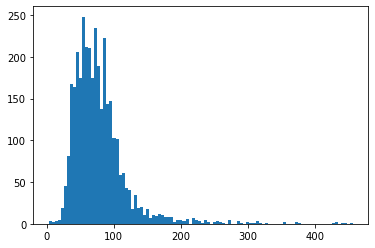

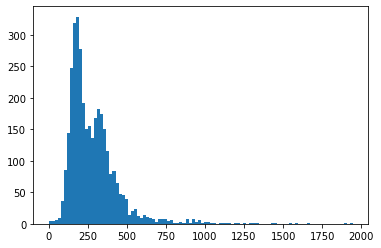

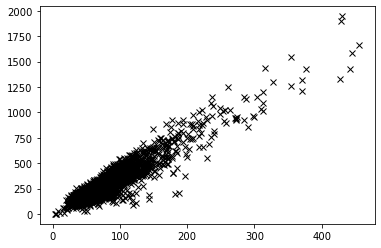

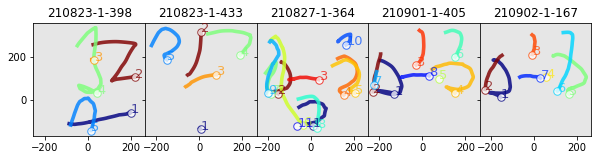

In [111]:
### Plot distribution of strokes, and plot trials falling below threshold.
THRESH = 30
import numpy as np
if True:
    list_badinds = []
    import matplotlib.pyplot as plt
    # To plot distribution of stroke distances
    from pythonlib.drawmodel.features import strokeDistances
    
    listns = []
    listdists = []
    for i in range(len(D.Dat)):
        strokes = D.Dat.iloc[i]["strokes_beh"]
        for s in strokes:
            listns.append(len(s))
        dists = strokeDistances(strokes)
        listdists.extend(dists)
        if any([d < THRESH for d in dists]):
            print(i, dists)
            list_badinds.append(i)

    plt.figure()
    plt.hist(listns, 100)
    plt.figure()
    plt.hist(listdists, 100)
    plt.figure()
    plt.plot(listns, listdists, "xk")
    
    D.plotMultTrials(list_badinds, nrand=24)

skipping differnetiation, stroke too short. giving NAN
skipping differnetiation, stroke too short. giving NAN
skipping differnetiation, stroke too short. giving NAN
skipping differnetiation, stroke too short. giving NAN
skipping differnetiation, stroke too short. giving NAN


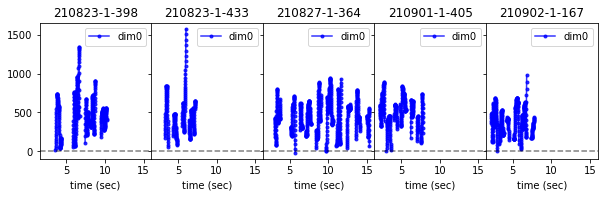

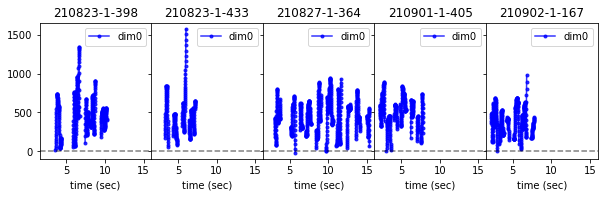

In [118]:
# Plot timecourses to see whether stroke at go cue
D.plotMultTrialsTimecourse(list_badinds, align_to="first_stroke_onset")

In [ ]:
# Filter, to remove strokes based ont eh following criteria

# find fixation and done locations
dat = D.Dat.iloc[ind]

dat["origin"]
dat["donepos"]

# find time of go
dat["motorevents"

In [125]:
# print an example stroke
ind = list_badinds[1]
D.Dat.iloc[ind]["strokes_beh"]

[array([[   6.        , -138.        ,    2.176     ],
        [   6.        , -138.        ,    2.184     ],
        [   6.        , -138.        ,    2.192     ],
        [   6.        , -138.        ,    2.2       ],
        [   6.        , -138.        ,    2.208     ],
        [   6.        , -138.        ,    2.216     ],
        [   6.        , -138.        ,    2.224     ],
        [   5.9267767 , -137.85355339,    2.232     ],
        [   5.6767767 , -137.35355339,    2.24      ],
        [   5.25      , -136.5       ,    2.248     ],
        [   4.71338835, -135.46338835,    2.256     ],
        [   4.16161165, -134.48483496,    2.264     ],
        [   3.6982233 , -133.77144661,    2.272     ],
        [   3.375     , -133.375     ,    2.28      ],
        [   3.16161165, -133.16161165,    2.288     ],
        [   3.03661165, -133.03661165,    2.296     ]]),
 array([[ 7.98887307e+00,  3.16972217e+02,  3.31200000e+00],
        [ 8.15241774e+00,  3.17721395e+02,  3.32000000e+0

In [ ]:
THRESH = 10 # min num pts. Remove any trial for which all traj in strokes are shorter than this.
def F(x):
    strokes = x["strokes_beh"]
    tmp = [len(s)<THRESH for s in strokes]
    if all(tmp):
        return True
    else:
        return False
D.Dat = applyFunctionToAllRows(D.Dat, F, "tmp")